# Landau

Finsler et cas de révolution

## Packages

In [1]:
import sys
sys.path.insert(1, '../')
#
import math
import numpy as np              # scientific computing tools
import wrappers                 # for compilation of Fortran Hamiltonian codes
import geometry2d.database
import geometry2d.conjugate
import geometry2d.errors
import geometry2d.geodesic
import geometry2d.plottings
import geometry2d.problem
import geometry2d.splitting
import geometry2d.utils
import geometry2d.wavefront
import geometry2d.sphere
import nutopy as nt
import scipy
import matplotlib.pyplot as plt # for plots
%matplotlib inline

In [2]:
#
color_hyperbolic_2D = 'red'
color_hyperbolic_3D = (1.0, 0.2, 0.2)
color_elliptic_2D = 'blue'
color_elliptic_3D = (0.2, 0.2, 1.0)
color_abnormal_2D = (0.2, 0.8, 0.2) #'green'
color_abnormal_3D = (0.2, 1.0, 0.2)
color_cut_locus  = 'black'
color_conjugate  = 'magenta'
color_wavefront  = 'orange'
color_sphere     = 'orange'
#
color_strong_domain_2d = 'lightblue'
color_strong_domain_3d = 'black'
#
PLANE = geometry2d.plottings.Coords.PLANE
SPHERE = geometry2d.plottings.Coords.SPHERE

## Fortran Hamiltonian code

In [3]:
# print Fortran code of the Hamiltonian: print hfun.f90 file
with open('hfun.f90', 'r') as f:
    print(f.read())

! Landau
subroutine hfun(x, p, c, h)

    double precision, intent(in)  :: x(2), p(2), c(4)
    double precision, intent(out) :: h

    ! local variables
    double precision :: r, th, pr, pth
    double precision :: m2, a, g1, g2, g3, cr, sr, ct, st, mu1, mu2

    r   = x(1)
    th  = x(2)

    pr  = p(1)
    pth = p(2)

    cr = cos(r)
    sr = sin(r)
    ct = cos(th)
    st = sin(th)

    g1 = c(1)
    g2 = c(2)
    g3 = c(3)
    a  = c(4)

    mu1 = a*g1*cr*sr+(g2-g3)*ct*st*sr-a*(g2*ct**2+g3*st**2)*cr*sr 
    mu2 = a*(g2-g3)*ct*st-g1*cr+(g3*st**2+g2*ct**2)*cr

    m2   = sin(r)**2

    h   = mu1*pr + mu2*pth + sqrt(pr**2 + pth**2/m2)

end subroutine hfun


## Initializations

In [4]:
def m2(r):
    return np.sin(r)**2

def g2_Landau(r):
    return m2(r)

def initialize(θ0, r0, γ1, γ2, γ3, α):

    # Parameters
    λ = [γ1, γ2, γ3, α] # parameters of the Hamiltonian
    t0 = 0.0        # initial time

    name = 'landau' # name of the problem

    # Initialize data
    data_file = 'data_landau.json'
    restart   = False # restart or not the computations
    data      = geometry2d.database.Data({'name': name,
                        't0': t0, 
                        'r0': r0, 
                        'θ0': θ0, 
                        'λ': λ}, data_file, restart)

    # Initial point
    q0 = np.array([r0, θ0])

    # Hamiltonian and derivatives up to order 3
    H = wrappers.hamiltonian(np.array(λ), compile=False, display=False)

    # The Riemannian metric associated to the Zermelo problem
    # g = g1 dr^2 + g2 dθ^2
    def g(q):
        r  = q[0] 
        g1 = 1.0
        g2 = g2_Landau(r)
        return g1, g2

    # problem
    prob = geometry2d.problem.GeometryProblem2D(name, H, g, t0, q0, data, 
                                                steps_for_geodesics=200, modulo=2*np.pi)
    
    return prob

## Parameterization of the geodesics

In [5]:
# gamma2-gamma1
def K_fun(alpha, delta):
    return delta**2*(1+alpha**2)/4.0

def domain_strong_current(alpha, delta):
    #
    K = K_fun(alpha, delta)
    
    # North hemisphere
    rp1 = math.asin(1/np.sqrt(K))/2.0
    rp2 = (math.pi - math.asin(1/np.sqrt(K))) / 2.0

    # South hemisphere
    rm1 = (-math.asin(1/np.sqrt(K)) % (2*np.pi) )/2.0
    rm2 = (math.pi + math.asin(1/np.sqrt(K))) / 2.0
    
    return rp1, rp2, rm1, rm2

In [6]:
def update_2d_plot(fig):
    ax = fig.axes[0]
    # set xlims
    ax.set_xlim(-np.pi/3, 2*np.pi + np.pi/3)
    # add vertical lines
    ax.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    ax.axvline(1*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    ax.axvline(1*np.pi/2, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    ax.axvline(3*np.pi/2, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    # set ylabel to "r" 
    ax.set_ylabel(r'$r$', rotation=0, labelpad=10)
    # set yticks: 0 => \pi/2, pi/2 => \pi, -pi/2 => 0
    ax.set_yticks([-np.pi/2, 0.0, np.pi/2])
    ax.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    # set xticks: 0, pi and 2pi
    ax.set_xticks([0.0, np.pi, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
    return fig

## Problem definition

In [7]:
alpha_Landau = 1.0
delta_Landau = 1.0 # gamma2-gamma1

K = K_fun(alpha_Landau, delta_Landau)
print("K = " + str(K))

if K > 1:
    raise ValueError('K should be > 1')

θ0 = 0.0
r0 = np.pi/2.0 
γ1 = 1.0
γ2 = γ1+delta_Landau
γ3 = γ2
α  = alpha_Landau
    
prob = initialize(θ0, r0, γ1, γ2, γ3, α)

geodesic = geometry2d.geodesic.Geodesic(prob)

K = 0.5


In [8]:
import numpy as np

def orthogonal_basis(v):
    """
    Trouve une base du plan orthogonal au vecteur v dans R^3.
    
    Paramètre:
    v : array-like de taille (3,), vecteur normal au plan.
    
    Retourne:
    (u1, u2) : deux vecteurs formant une base du plan orthogonal à v.
    """
    a, b, c = v

    # Choix de deux vecteurs orthogonaux à v
    if c != 0:
        u1 = np.array([1, 0, -a/c])
        u2 = np.array([0, 1, -b/c])
    elif b != 0:
        u1 = np.array([1, -a/b, 0])
        u2 = np.array([0, 0, 1])
    else:  # Cas où v est de la forme (a,0,0), son plan orthogonal est le plan yz
        u1 = np.array([0, 1, 0])
        u2 = np.array([0, 0, 1])
    
    return u1, u2

# Exemple d'utilisation
v = np.array([1, 2, 3])
u1, u2 = orthogonal_basis(v)

print("Vecteur normal :", v)
print("Base du plan orthogonal :")
print("u1 =", u1)
print("u2 =", u2)

# Vérification
print("Produit scalaire v · u1 :", np.dot(v, u1))  # Doit être proche de 0
print("Produit scalaire v · u2 :", np.dot(v, u2))  # Doit être proche de 0


Vecteur normal : [1 2 3]
Base du plan orthogonal :
u1 = [ 1.          0.         -0.33333333]
u2 = [ 0.          1.         -0.66666667]
Produit scalaire v · u1 : 0.0
Produit scalaire v · u2 : 0.0


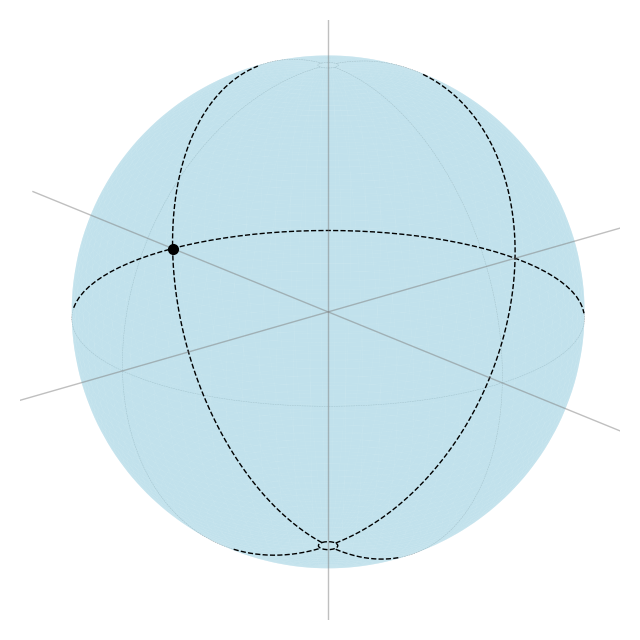

<Figure size 640x480 with 0 Axes>

In [9]:
# 3D plot
cam={'azimuth': 140, 'elevation': 20}
azimuth = cam['azimuth']
elevation = cam['elevation']
figure = geometry2d.plottings.init_figure_3d(
    prob.epsilon, 
    prob.initial_point,
    elevation,
    azimuth, dpi=200, figsize=(3,3))
figure

## Geodesic flow

In [10]:
αspan = np.linspace(0, 2*np.pi, 20)
tf = 3*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 120, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

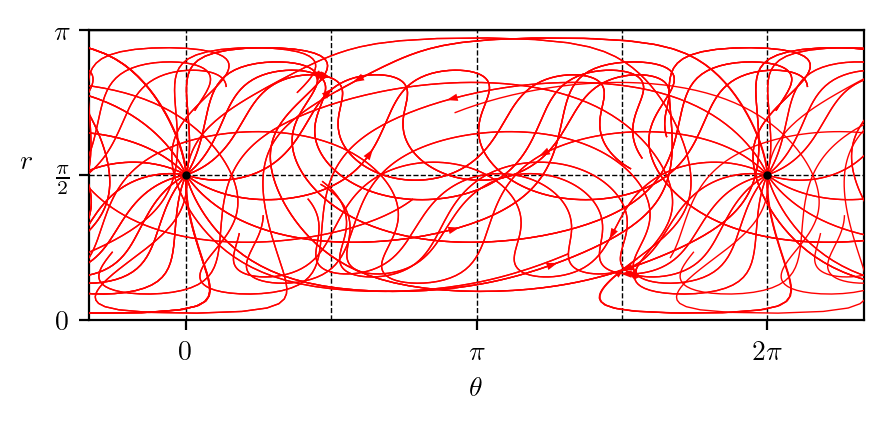

In [11]:
fig2d

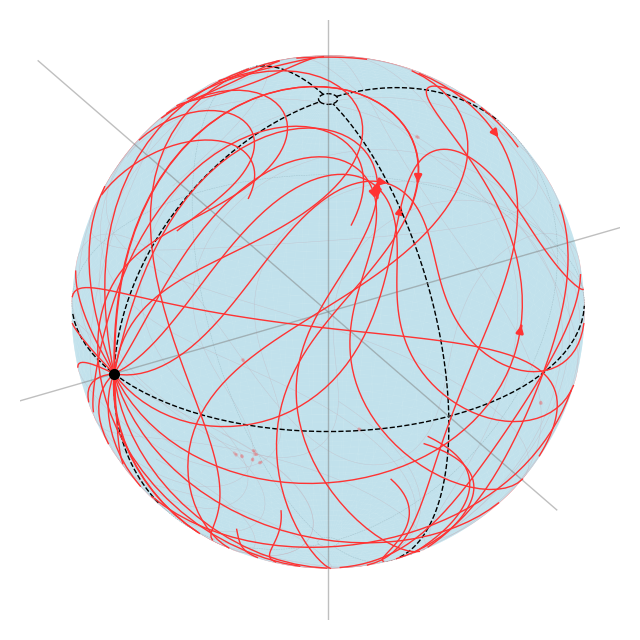

In [12]:
figs3d[0]

## Conjugate locus

In [13]:
conjugate  = geometry2d.conjugate.Conjugate(prob)
conj_locus = conjugate.compute(load=True, gap=1e-4)

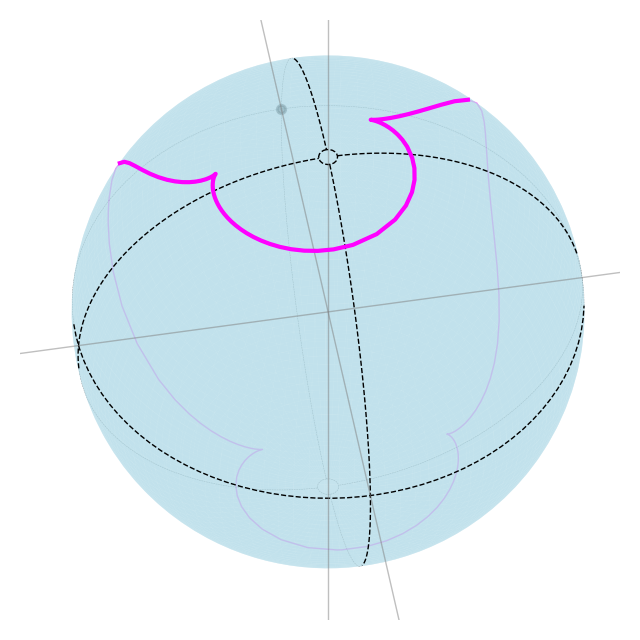

<Figure size 640x480 with 0 Axes>

In [35]:
LW_CONJ = 1.5

#
fig2d = conjugate.plot(view=PLANE, color=color_conjugate, linestyle='solid', linewidth=LW_CONJ, figsize=(5,5))
fig2d = update_2d_plot(fig2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 120, 'elevation': -10}]
cameras=[{'azimuth': 10, 'elevation': -50}, {'azimuth': 110, 'elevation': -10}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = conjugate.plot(view=SPHERE, azimuth=azimuth, elevation=elevation, figsize=(3,3), 
                           color=color_conjugate, linestyle='solid', linewidth=LW_CONJ, plot_surface=False)
    figs3d.append(fig3d)
    
figs3d[0]

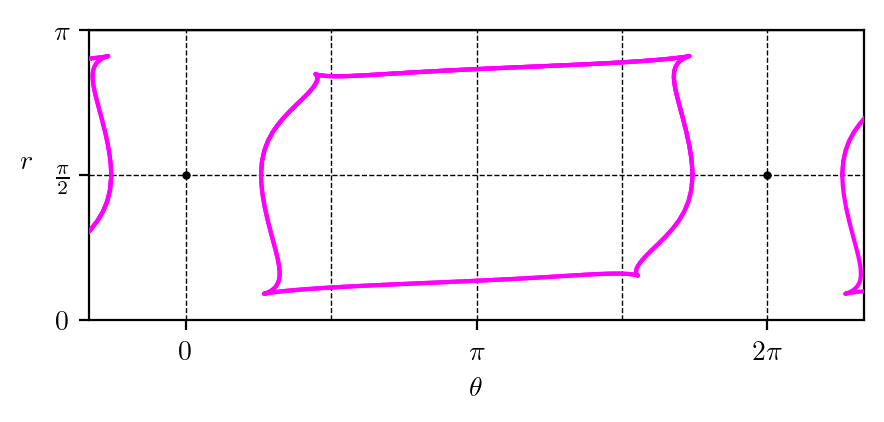

In [36]:
fig2d.savefig('landau_finsler_2D_with_conjugate_locus.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d

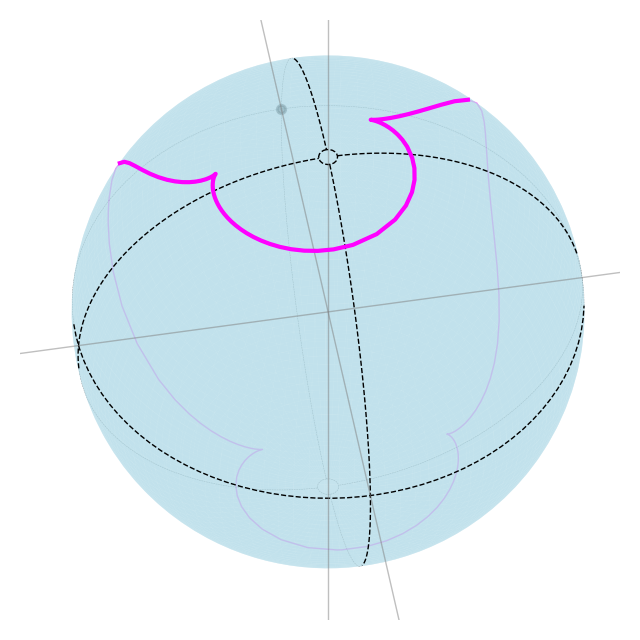

In [37]:
figs3d[0].savefig('landau_finsler_3D_with_conjugate_locus.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

In [38]:
# add geodesics
αspan = np.linspace(np.pi/5, np.pi/2, 10)
αspan = np.linspace(-np.pi/8, -np.pi/3, 7)
tf = conjugate.conjugate_time(conj_locus)

#
fig2d = geodesic.plot(alphas=αspan, tf=geodesic.return_to_equator, length=1, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

#
for fig3d in figs3d:
    geodesic.plot(alphas=αspan, tf=geodesic.return_to_equator, view=SPHERE, color=color_hyperbolic_3D, figure=fig3d)

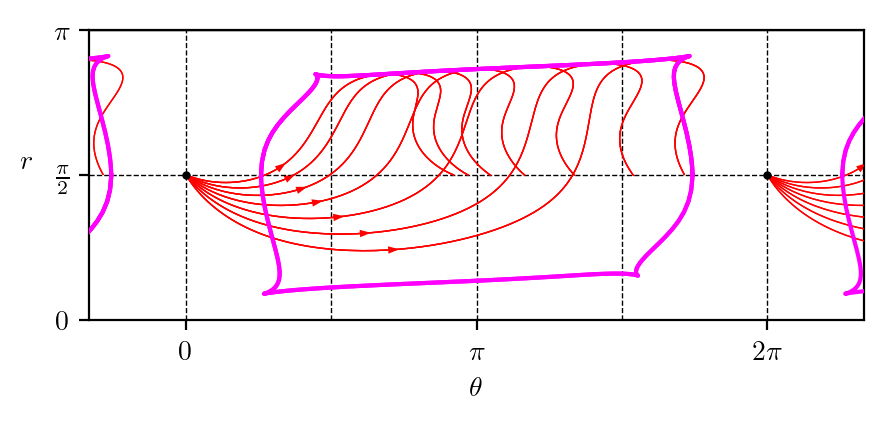

In [39]:
fig2d.savefig('landau_finsler_2D_with_conjugate_locus_with_geodesics.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d

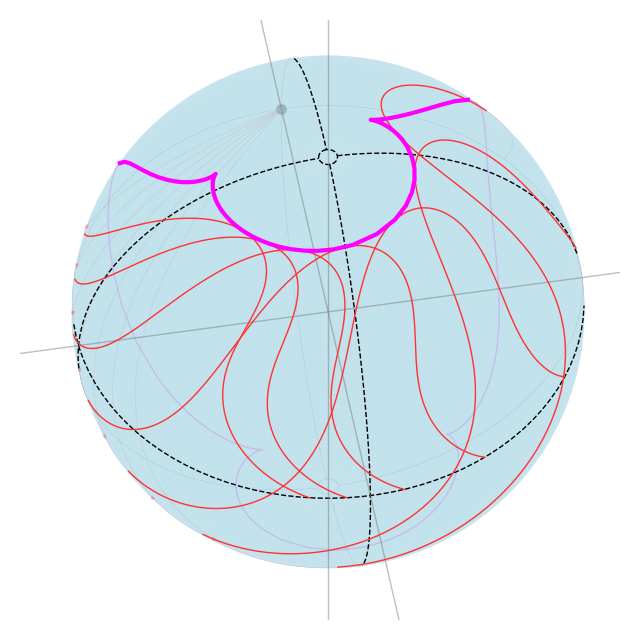

In [40]:
figs3d[0].savefig('landau_finsler_3D_with_conjugate_locus_with_geodesics.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[0]

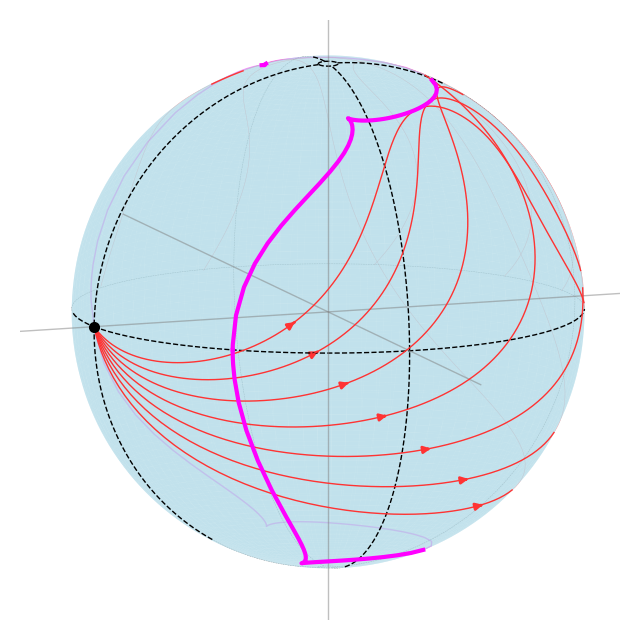

In [41]:
figs3d[1].savefig('landau_finsler_3D_with_conjugate_locus_with_geodesics_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d[1]

# Pseudo-meridians and injectivity radius

In [42]:
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint

In [43]:
# we search the geodesic reaching the North pole

epsilon=1e-5

# Cost function J
def J(y):
    tf = y[0]
    α0 = y[1]
    return tf

# Equality nonlinear constraints h
def h(y):
    tf = y[0]
    α0 = y[1]
    x  = geodesic.compute(tf, α0)
    return (x[-1][0]-np.pi)**2-epsilon

nlcons = NonlinearConstraint(h, 0., 0.)

# bounds
bnds   = ((0., np.pi), (0., 2*np.pi))

Nfeval = 1
print('\n Niter  tf          α0          J              h')
def callbackF(yi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6e}  {4: 3.6e}'.format(\
        Nfeval, yi[0], yi[1], J(yi), np.linalg.norm(h(yi))))
    Nfeval += 1

y_init = np.array([1.2, np.pi/2] ) # Initialization guessed from Figure 5 of [Boumaza et al. 2020]

res    = minimize(J, y_init, method='SLSQP', constraints={nlcons}, bounds=bnds,
                  options={'disp': True, 'ftol':1e-6, 'eps': 1e-8, 'maxiter': 100}, callback=callbackF)
ysol   = res.x

print('')
print('Optimal results = [{0:3.4f}, {1:3.4f}]'.format(res.x[0], res.x[1]))
print('Equality NL constraints = {0: 3.6e}'.format(np.linalg.norm(h(res.x))))

t_North_pole = res.x[0]
α_North_pole = res.x[1]


 Niter  tf          α0          J              h
   1    1.204043    1.570796    1.204043e+00   1.673148e-05
   2    1.204061    1.570849    1.204061e+00   1.654748e-05
   3    1.205509    1.556121    1.205509e+00   2.136110e-04
   4    1.205660    1.570898    1.205660e+00   2.584855e-06
   5    1.205858    1.570807    1.205858e+00   1.204641e-06
   6    1.206037    1.570792    1.206037e+00   3.268732e-08
   7    1.206042    1.570798    1.206042e+00   6.320774e-11
   8    1.206042    1.570798    1.206042e+00   6.320774e-11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2060422784510811
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 8

Optimal results = [1.2060, 1.5708]
Equality NL constraints =  6.320774e-11


In [44]:
# we search the geodesic reaching the South pole

# Cost function J
def J(y):
    tf = y[0]
    α0 = y[1]
    return tf

# Equality nonlinear constraints h
def h(y):
    tf = y[0]
    α0 = y[1]
    x  = geodesic.compute(tf, α0)
    return (x[-1][0])**2-epsilon

nlcons = NonlinearConstraint(h, 0., 0.)

# bounds
bnds   = ((0., np.pi), (0., 2*np.pi))

Nfeval = 1
print('\n Niter  tf          α0          J              h')
def callbackF(yi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6e}  {4: 3.6e}'.format(\
        Nfeval, yi[0], yi[1], J(yi), np.linalg.norm(h(yi))))
    Nfeval += 1

y_init = np.array([1.2, 3*np.pi/2] ) # Initialization guessed from Figure 5 of [Boumaza et al. 2020]

res    = minimize(J, y_init, method='SLSQP', constraints={nlcons}, bounds=bnds,
                  options={'disp': True, 'ftol':1e-6, 'eps': 1e-8, 'maxiter': 100}, callback=callbackF)
ysol   = res.x

print('')
print('Optimal results = [{0:3.4f}, {1:3.4f}]'.format(res.x[0], res.x[1]))
print('Equality NL constraints = {0: 3.6e}'.format(np.linalg.norm(h(res.x))))

t_South_pole = res.x[0]
α_South_pole = res.x[1]


 Niter  tf          α0          J              h
   1    1.204043    4.712388    1.204043e+00   1.673149e-05
   2    1.204061    4.712449    1.204061e+00   1.654841e-05
   3    1.205464    4.695853    1.205464e+00   2.696107e-04
   4    1.205660    4.712468    1.205660e+00   2.581527e-06
   5    1.205862    4.712398    1.205862e+00   1.173651e-06
   6    1.206037    4.712385    1.206037e+00   3.108072e-08
   7    1.206042    4.712391    1.206042e+00   6.245483e-11
   8    1.206042    4.712391    1.206042e+00   6.245483e-11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2060422786178624
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 8

Optimal results = [1.2060, 4.7124]
Equality NL constraints =  6.245483e-11


In [45]:
# search the geodesic having the smallest conjugate time: right part

# Cost function J
def J(y):
    tc = y[0]
    α0 = y[1]
    return tc

# Equality nonlinear constraints h
def h(y):
    tc = y[0]
    α0 = y[1]
    return prob.conjugate(tc, α0)

nlcons = NonlinearConstraint(h, 0., 0.)

# bounds
bnds   = ((0., np.pi), (0., np.pi/2))

Nfeval = 1
print('\n Niter  tf          α0          J              h')
def callbackF(yi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6e}  {4: 3.6e}'.format(\
        Nfeval, yi[0], yi[1], J(yi), np.linalg.norm(h(yi))))
    Nfeval += 1

y_init = np.array([1.6, np.pi/2-0.1] ) # Initialization guessed from Figure 5 of [Boumaza et al. 2020]

res    = minimize(J, y_init, method='SLSQP', constraints={nlcons}, bounds=bnds,
                  options={'disp': True, 'ftol':1e-6, 'eps': 1e-8, 'maxiter': 100}, callback=callbackF)
ysol   = res.x

print('')
print('Optimal results = [{0:3.4f}, {1:3.4f}]'.format(res.x[0], res.x[1]))
print('Equality NL constraints = {0: 3.6e}'.format(np.linalg.norm(h(res.x))))

t_conj_right = res.x[0]
α_conj_right = res.x[1]


 Niter  tf          α0          J              h
   1    1.135591    0.850840    1.135591e+00   6.650238e-01
   2    1.419626    0.409501    1.419626e+00   3.082892e-01
   3    1.698510    0.539881    1.698510e+00   4.782434e-02
   4    1.734562    0.760975    1.734562e+00   1.991506e-02
   5    1.771490    0.675228    1.771490e+00   2.885577e-03
   6    1.777065    0.700929    1.777065e+00   5.225196e-04
   7    1.778260    0.690253    1.778260e+00   2.766874e-05
   8    1.778321    0.692619    1.778321e+00   1.458991e-06
   9    1.778325    0.692624    1.778325e+00   2.468023e-11
  10    1.778325    0.692624    1.778325e+00   2.468023e-11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7783248613445624
            Iterations: 10
            Function evaluations: 31
            Gradient evaluations: 10

Optimal results = [1.7783, 0.6926]
Equality NL constraints =  2.468023e-11


In [46]:
# search the geodesic having the smallest conjugate time: left part

# Cost function J
def J(y):
    tc = y[0]
    α0 = y[1]
    return tc

# Equality nonlinear constraints h
def h(y):
    tc = y[0]
    α0 = y[1]
    return prob.conjugate(tc, α0)

nlcons = NonlinearConstraint(h, 0., 0.)

# bounds
bnds   = ((0., np.pi), (np.pi, 3*np.pi/2))

Nfeval = 1
print('\n Niter  tf          α0          J              h')
def callbackF(yi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6e}  {4: 3.6e}'.format(\
        Nfeval, yi[0], yi[1], J(yi), np.linalg.norm(h(yi))))
    Nfeval += 1

y_init = np.array([1.6, 3*np.pi/2-0.1] ) # Initialization guessed from Figure 5 of [Boumaza et al. 2020]

res    = minimize(J, y_init, method='SLSQP', constraints={nlcons}, bounds=bnds,
                  options={'disp': True, 'ftol':1e-6, 'eps': 1e-8, 'maxiter': 100}, callback=callbackF)
ysol   = res.x

print('')
print('Optimal results = [{0:3.4f}, {1:3.4f}]'.format(res.x[0], res.x[1]))
print('Equality NL constraints = {0: 3.6e}'.format(np.linalg.norm(h(res.x))))

t_conj_left = res.x[0]
α_conj_left = res.x[1]


 Niter  tf          α0          J              h
   1    1.135591    3.992432    1.135591e+00   6.650238e-01
   2    1.419626    3.551093    1.419626e+00   3.082890e-01
   3    1.698510    3.681474    1.698510e+00   4.782432e-02
   4    1.734561    3.902568    1.734561e+00   1.991517e-02
   5    1.771490    3.816820    1.771490e+00   2.885704e-03
   6    1.777065    3.842521    1.777065e+00   5.225465e-04
   7    1.778260    3.831846    1.778260e+00   2.766805e-05
   8    1.778321    3.834211    1.778321e+00   1.458759e-06
   9    1.778325    3.834217    1.778325e+00   2.346955e-11
  10    1.778325    3.834217    1.778325e+00   2.346955e-11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7783248614847749
            Iterations: 10
            Function evaluations: 31
            Gradient evaluations: 10

Optimal results = [1.7783, 3.8342]
Equality NL constraints =  2.346955e-11


In [47]:
# we search the geodesics with the greatest cut time

# Cost function J
def J(y):
    tc = y[0]
    α0 = y[1]
    α1 = y[2]
    return -tc

# Equality nonlinear constraints h
modulo = 2*np.pi
def h(y):
    tc = y[0]
    α0 = y[1]
    α1 = y[2]
    x1  = geodesic.compute(tc, α0)
    x2  = geodesic.compute(tc, α1)
    #return (x1[-1] % modulo) - (x2[-1] % modulo)
    return np.array([ (x1[-1][0] % modulo) - (x2[-1][0] % modulo), ((x1[-1][1]+2*np.pi) % modulo) - ((x2[-1][1]+2*np.pi) % modulo) ])

nlcons = NonlinearConstraint(h, np.array([0., 0.]), np.array([0., 0.]))

# bounds
bnds   = ((1.0, 3.0), (-1.0, -0.8), (2.0, 2.5))

Nfeval = 1
print('\n Niter  tc          α0          α1              J              h')
def callbackF(yi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6e}   {4: 3.6e}  {5: 3.6e}'.format(\
        Nfeval, yi[0], yi[1], yi[2], J(yi), np.linalg.norm(h(yi))))
    Nfeval += 1

y_init = np.array([2.5, -0.9, 2.25] ) # Initialization guessed from Figure 5 of [Boumaza et al. 2020]

res    = minimize(J, y_init, method='SLSQP', constraints={nlcons}, #bounds=bnds,
                  options={'disp': True, 'ftol':1e-6, 'eps': 1e-8, 'maxiter': 10}, callback=callbackF)
ysol   = res.x

print('')
print('Optimal results = [{0:3.4f}, {1:3.4f}, {2:3.4f}]'.format(res.x[0], res.x[1], res.x[2]))
print('Equality NL constraints = {0: 3.6e}'.format(np.linalg.norm(h(res.x))))

tf_cut_max = res.x[0]
α0_cut_max = res.x[1]
α1_cut_max = res.x[2]


 Niter  tc          α0          α1              J              h
   1    2.586392   -0.875493    2.245927e+00   -2.586392e+00   1.679367e-02
   2    2.585855   -0.892665    2.260772e+00   -2.585855e+00   3.470402e-03
   3    2.585127   -0.886970    2.254703e+00   -2.585127e+00   4.700611e-04
   4    2.584993   -0.886967    2.254629e+00   -2.584993e+00   8.590168e-08
   5    2.584993   -0.886967    2.254629e+00   -2.584993e+00   8.590168e-08
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.584993298911271
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5

Optimal results = [2.5850, -0.8870, 2.2546]
Equality NL constraints =  8.590168e-08


In [48]:
# on affiche les 4 trajectoires pour vérifier

fig2d = conjugate.plot(view=PLANE, color=color_conjugate, linestyle='solid', linewidth=LW_CONJ, figsize=(5,5))
fig2d = update_2d_plot(fig2d)

α0 = α_North_pole 
tf = t_North_pole
fig2d = geodesic.plot(alphas=[α0], tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

α0 = α_South_pole 
tf = t_South_pole
fig2d = geodesic.plot(alphas=[α0], tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

α0 = α_conj_right 
tf = t_conj_right
fig2d = geodesic.plot(alphas=[α0], tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

α0 = α_conj_left 
tf = t_conj_left
fig2d = geodesic.plot(alphas=[α0], tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

α0 = α0_cut_max 
tf = tf_cut_max
fig2d = geodesic.plot(alphas=[α0], tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

α0 = α1_cut_max 
tf = tf_cut_max
fig2d = geodesic.plot(alphas=[α0], tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d)

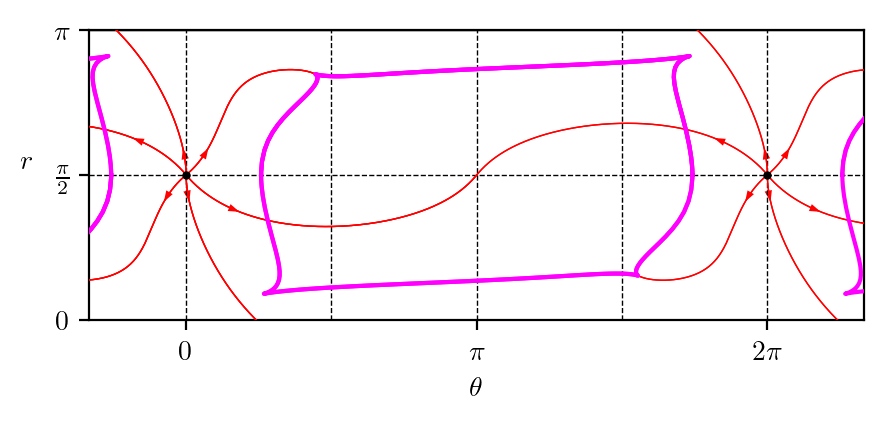

In [49]:
fig2d

## Wavefronts

In [81]:
wavefront = geometry2d.wavefront.WaveFront(prob)
tfs_wavefronts = np.arange(0.1, 3.5, 0.1)
tfs_wavefronts = [tf_cut_max, 1.25]
tfs_wavefronts = [0.45, 0.95]

gap=1e-3
αspan_right = [-(2*np.pi-α_South_pole)+gap, α_North_pole-gap]
αspan_left  = [α_North_pole+gap, α_South_pole-gap]

if True:
    for tf in tfs_wavefronts:
        wavefront.compute(tf, αspan_right, label='right', load=True)
        wavefront.compute(tf, αspan_left, label='left', load=True)

In [82]:
tfs = [0.2, 0.5, 0.7, 1.0, 1.2, 1.25, 1.5, 2.0, 2.5]#, tf_cut_max]
cameras=[{'azimuth': 120, 'elevation': -10}]

LW_WAVEFRONT_2D = 0.8
LW_WAVEFRONT_3D = 1.2

tfs = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.1, 2.3, 2.5])

tfs = np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4])

#tfs = np.array([0.2, 0.6, 1.2, 1.8, 2.4])
cameras=[{'azimuth': 40, 'elevation': -40}, {'azimuth': 140, 'elevation': -40}]

for i in range(len(tfs)):
    tf = tfs[i]
    if i == 0:
        fig2d_wavefront = wavefront.plot(tf, ['left', 'right'], view=PLANE, color=color_wavefront, linewidth=LW_WAVEFRONT_2D, figsize=(5,5))
        fig2d_wavefront = update_2d_plot(fig2d_wavefront)
        figs3d_wavefront = []
        for camera in cameras:
            azimuth = camera['azimuth']
            elevation = camera['elevation']
            fig3d_wavefront = wavefront.plot(tf, ['left', 'right'], view=SPHERE, color=color_wavefront, linewidth=LW_WAVEFRONT_3D,
                                             azimuth=azimuth, elevation=elevation, figsize=(3,3))
            figs3d_wavefront.append(fig3d_wavefront)
    else:
        wavefront.plot(tf, ['left', 'right'], view=PLANE, color=color_wavefront, linewidth=LW_WAVEFRONT_2D, figure=fig2d_wavefront)
        for fig3d_wavefront in figs3d_wavefront:
            wavefront.plot(tf, ['left', 'right'], view=SPHERE, color=color_wavefront, linewidth=LW_WAVEFRONT_3D, figure=fig3d_wavefront)
            
# add conjugate locus
LW_CONJ = 1.5

# PLANE
fig2d_wavefront = conjugate.plot(view=PLANE, color=color_conjugate, figure=fig2d_wavefront, linestyle='solid', linewidth=LW_CONJ)

# SPHERE
for fig3d in figs3d_wavefront:
    conjugate.plot(view=SPHERE, color=color_conjugate, figure=fig3d, linestyle='solid', linewidth=LW_CONJ, plot_surface=False)

<Figure size 640x480 with 0 Axes>

In [83]:
if False:
    ww = wavefront.compute(2.6)
    
    q = ww[0]['locus'].states
    r = q[:, 0] - np.pi/2
    θ = (q[:, 1] + 2*np.pi) - np.pi
    d = r**2+θ**2
    i = np.argmin(d)
    
    q = ww[1]['locus'].states
    r = q[:, 0] - np.pi/2
    θ = (q[:, 1]) - np.pi
    d = r**2+θ**2
    j = np.argmin(d)
    
    alpha = ww[0]['locus'].alphas[i]
    alpha

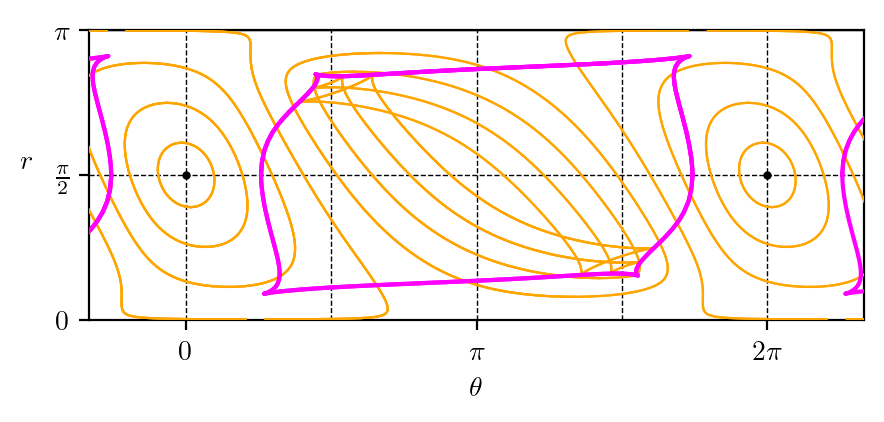

In [84]:
fig2d_wavefront.savefig('landau_finsler_wavefronts_2D_with_conjugate_locus.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_wavefront

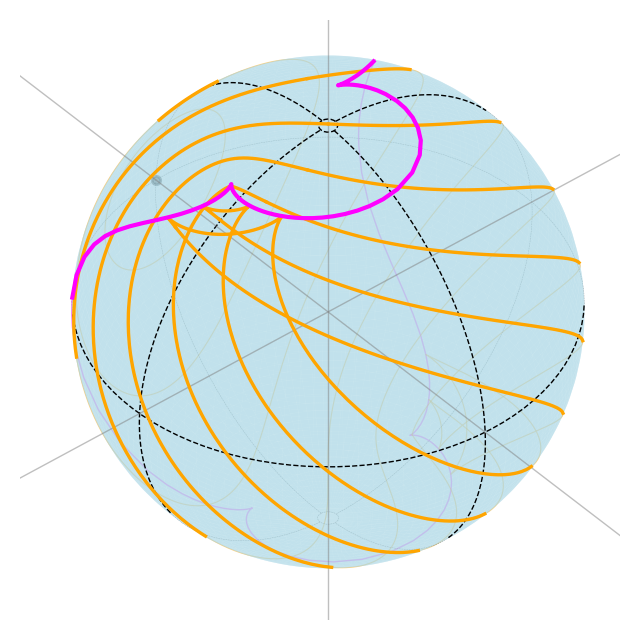

In [85]:
figs3d_wavefront[0].savefig('landau_finsler_wavefronts_3D_with_conjugate_locus.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_wavefront[0]

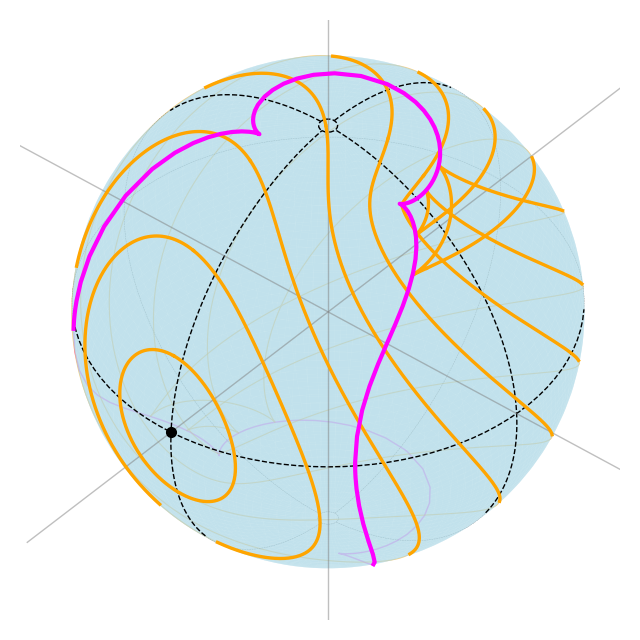

In [86]:
figs3d_wavefront[1].savefig('landau_finsler_wavefronts_3D_with_conjugate_locus_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_wavefront[1]

## Cut locus

In [56]:
splitting = geometry2d.splitting.Splitting(prob)

In [57]:
7.85 % (2*np.pi)

1.5668146928204134

In [58]:
def find_intersections(tf, labels):
        
    # on parcoure les labels et on concatène states et alphas
    for i in range(len(labels)):
        label = labels[i]
        w = wavefront.get_from_label__(tf, label)['locus']
        if i==0:
            states = w.states
            alphas = w.alphas
        else:
            states = np.concatenate((states, w.states))
            alphas = np.concatenate((alphas, w.alphas))
    
    # on remet tout entre 0 et 2pi
    states = (states + 2*np.pi) % (2*np.pi)
    alphas = (alphas + 2*np.pi) % (2*np.pi)
    
    # on ordonne les alphas
    ind = np.argsort(alphas)
    alphas = alphas[ind]
    states = states[ind, :]
    
    # on calcule les intersections
    intersections = wavefront.get_data_from_self_intersections(tf, states, alphas)

    return intersections

labels=['left', 'right']

tf = 2.0
intersections = find_intersections(tf, labels)
print(intersections)
inter_conj_right_north_pole = intersections[0]
tf = inter_conj_right_north_pole[0]
a1 = inter_conj_right_north_pole[1]
a2 = inter_conj_right_north_pole[2]
q  = inter_conj_right_north_pole[3]
inter_conj_right_north_pole = (tf, a2, a1, q)
inter_conj_left_south_pole = intersections[1]

tf = 2.5
intersections = find_intersections(tf, labels)
print(intersections)
inter_conj_north_pole_center = intersections[0]
tf = inter_conj_north_pole_center[0]
a1 = inter_conj_north_pole_center[1]
a2 = inter_conj_north_pole_center[2]
q  = inter_conj_north_pole_center[3]
inter_conj_north_pole_center = (tf, a2, a1, q)
inter_conj_south_pole_center = intersections[1]

print(prob.split_eq(tf, a1, a2))

[(2.0, 1.5304548320815368, 6.032287686103143, array([2.57105833, 1.581975  ])), (2.0, 2.890707816236743, 4.67207544808956, array([0.5705307 , 4.70120836]))]
[(2.5, 2.0715773637053587, 5.5369880875856206, array([2.05085967, 2.51622371])), (2.5, 2.3953867380932388, 5.213207971618419, array([1.09082527, 3.76681889]))]
[2.58640987e-05 1.99859157e-05]


In [59]:
# between conj right and north pole
gap = 1e-2
αspan = [α_conj_right+gap, α_North_pole-gap]
cut_locus_top = splitting.compute(inter_conj_right_north_pole, αspan, label='top', load=True)
t_cut_top = splitting.splitting_time(cut_locus_top)

# between conj left and south pole
gap = 1e-2
αspan = [α_conj_left+gap, α_South_pole-gap]
cut_locus_bottom = splitting.compute(inter_conj_left_south_pole, αspan, label='bottom', load=True)
t_cut_bottom = splitting.splitting_time(cut_locus_bottom)

# between north pole and center
gap = 1e-2
αspan = [α_North_pole+gap, α1_cut_max]
cut_locus_middle_north = splitting.compute(inter_conj_north_pole_center, αspan, 
                                           label='middle_north', load=True)
t_cut_middle_north = splitting.splitting_time(cut_locus_middle_north)

# between south pole and center
gap = 1e-2
αspan = [α_South_pole+gap, (α0_cut_max+2*np.pi)%(2*np.pi)]
cut_locus_middle_south = splitting.compute(inter_conj_south_pole_center, αspan, 
                                           label='middle_south', load=True)
t_cut_middle_south = splitting.splitting_time(cut_locus_middle_south)

## Optimal synthesis

In [60]:
LW_CUT = 1.8

# plot cut locus
fig2d_synthesis = splitting.plot(['top', 'bottom', 'middle_north', 'middle_south'], linewidth=LW_CUT, view=PLANE, color=color_cut_locus, figsize=(5,5))
fig2d_synthesis = update_2d_plot(fig2d_synthesis)

cameras=[{'azimuth': 40, 'elevation': -40}, {'azimuth': 140, 'elevation': -40}]
figs3d_synthesis = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d_synthesis = splitting.plot(['top', 'bottom', 'middle_north', 'middle_south'], linewidth=LW_CUT, view=SPHERE, color=color_cut_locus, azimuth=azimuth, elevation=elevation, figsize=(3,3))
    figs3d_synthesis.append(fig3d_synthesis)

<Figure size 640x480 with 0 Axes>

In [61]:
LW_CONJ = 1.5

# add hyperbolic conjugate points
fig2d_synthesis = conjugate.plot(linewidth=LW_CONJ, view=PLANE, color=color_conjugate, figure=fig2d_synthesis, linestyle='solid')

for fig3d_synthesis in figs3d_synthesis:
    conjugate.plot(linewidth=LW_CONJ, view=SPHERE, color=color_conjugate, figure=fig3d_synthesis, linestyle='solid', plot_surface=False)

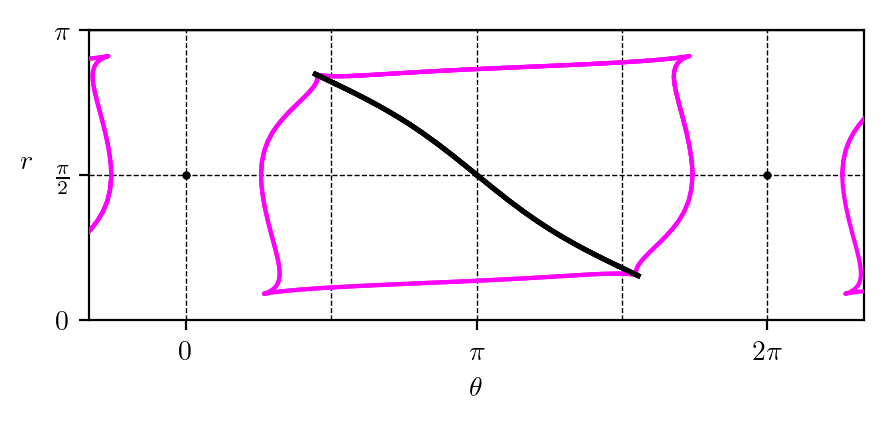

In [62]:
fig2d_synthesis.savefig('landau_finsler_cut_2D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_synthesis

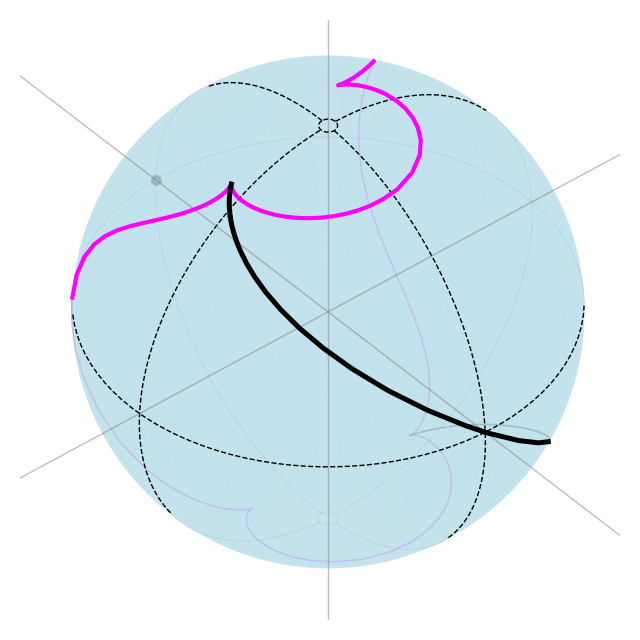

In [63]:
figs3d_synthesis[0].savefig('landau_finsler_cut_3D.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_synthesis[0]

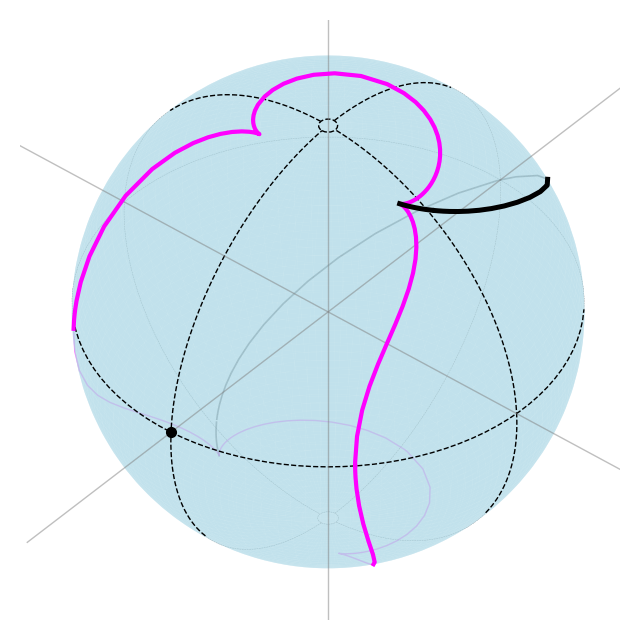

In [64]:
figs3d_synthesis[1].savefig('landau_finsler_cut_3D_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_synthesis[1]

# Cut + géodésiques

In [65]:
def dist(x, E):
    i = np.argmin(np.abs(x-E))
    d = np.min(np.abs(x-E))
    return d, i

cut_locus_top.alphas          = (cut_locus_top.alphas+2*np.pi) % (2*np.pi)
cut_locus_bottom.alphas       = (cut_locus_bottom.alphas+2*np.pi) % (2*np.pi)
cut_locus_middle_north.alphas = (cut_locus_middle_north.alphas+2*np.pi) % (2*np.pi)
cut_locus_middle_south.alphas = (cut_locus_middle_south.alphas+2*np.pi) % (2*np.pi)

def t_cut_final(α):
    α = α % (2.0*np.pi)
    d = np.Inf
    t = t_cut_top
    e, i = dist(α, cut_locus_top.alphas[:,0])
    if e < d:
        d = e
        t = t_cut_top
    e, i = dist(α, cut_locus_top.alphas[:,1])
    if e < d:
        d = e
        t = t_cut_top
    e, i = dist(α, cut_locus_bottom.alphas[:,0])
    if e < d:
        d = e
        t = t_cut_bottom
    e, i = dist(α, cut_locus_bottom.alphas[:,1])
    if e < d:
        d = e
        t = t_cut_bottom
    e, i = dist(α, cut_locus_middle_north.alphas[:,0])
    if e < d:
        d = e
        t = t_cut_middle_north
    e, i = dist(α, cut_locus_middle_north.alphas[:,1])
    if e < d:
        d = e
        t = t_cut_middle_north
    e, i = dist(α, cut_locus_middle_south.alphas[:,0])
    if e < d:
        d = e
        t = t_cut_middle_south
    e, i = dist(α, cut_locus_middle_south.alphas[:,1])
    if e < d:
        d = e
        t = t_cut_middle_south
    return t(α)

def α_cut_final(α):
    α = α % (2.0*np.pi)
    d = np.Inf
    b = 0.0
    e, i = dist(α, cut_locus_top.alphas[:,0])
    if e < d:
        d = e
        b = cut_locus_top.alphas[i,1]
    e, i = dist(α, cut_locus_top.alphas[:,1])
    if e < d:
        d = e
        b = cut_locus_top.alphas[i,0]
    e, i = dist(α, cut_locus_bottom.alphas[:,0])
    if e < d:
        d = e
        b = cut_locus_bottom.alphas[i,1]
    e, i = dist(α, cut_locus_bottom.alphas[:,1])
    if e < d:
        d = e
        b = cut_locus_bottom.alphas[i,0]
    e, i = dist(α, cut_locus_middle_north.alphas[:,0])
    if e < d:
        d = e
        b = cut_locus_middle_north.alphas[i,1]
    e, i = dist(α, cut_locus_middle_north.alphas[:,1])
    if e < d:
        d = e
        b = cut_locus_middle_north.alphas[i,0]
    e, i = dist(α, cut_locus_middle_south.alphas[:,0])
    if e < d:
        d = e
        b = cut_locus_middle_south.alphas[i,1]
    e, i = dist(α, cut_locus_middle_south.alphas[:,1])
    if e < d:
        d = e
        b = cut_locus_middle_south.alphas[i,0]
        
    # we improve the result
    tc   = t_cut_final(α)
    q    = geodesic.compute(tc, α)
    fun  = lambda y: prob.split_fun(y, [α])
    opt  = nt.nle.Options(Display='off')
    y    = np.zeros(4)
    y[0] = tc
    y[1] = b
    y[2:4] = q[-1] % (2*np.pi)
    sol  = nt.nle.solve(fun, y, options=opt)
    return sol.x[1], sol.x[0]

def t_cut_improved(α):
    b, tc = α_cut_final(α)
    return tc


In [66]:
LW_CUT = 1.8

# plot cut locus
fig2d_synthesis = splitting.plot(['top', 'bottom', 'middle_north', 'middle_south'], linewidth=LW_CUT, view=PLANE, color=color_cut_locus, figsize=(5,5))
fig2d_synthesis = update_2d_plot(fig2d_synthesis)

cameras=[{'azimuth': 40, 'elevation': -40}, {'azimuth': 140, 'elevation': -40}]
figs3d_synthesis = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d_synthesis = splitting.plot(['top', 'bottom', 'middle_north', 'middle_south'], linewidth=LW_CUT, view=SPHERE, color=color_cut_locus, azimuth=azimuth, elevation=elevation, figsize=(3,3))
    figs3d_synthesis.append(fig3d_synthesis)

# add geodesics
αspan1 = np.linspace(α0_cut_max, α_conj_right, 5)
for i in range(len(αspan1)):
    α = αspan1[i]
    b, tc = α_cut_final(α)
    αspan1 = np.append(αspan1, [b])

αspan2 = np.linspace(α1_cut_max, α_conj_left, 5)
for i in range(len(αspan2)):
    α = αspan2[i]
    b, tc = α_cut_final(α)
    αspan2 = np.append(αspan2, [b])

αspan = np.concatenate((αspan1, αspan2))
tf = t_cut_improved

#
geodesic.plot(alphas=αspan, tf=tf, view=PLANE, color=color_hyperbolic_2D, figure=fig2d_synthesis)

#
for fig3d_synthesis in figs3d_synthesis:
    geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, color=color_hyperbolic_3D, figure=fig3d_synthesis)

<Figure size 640x480 with 0 Axes>

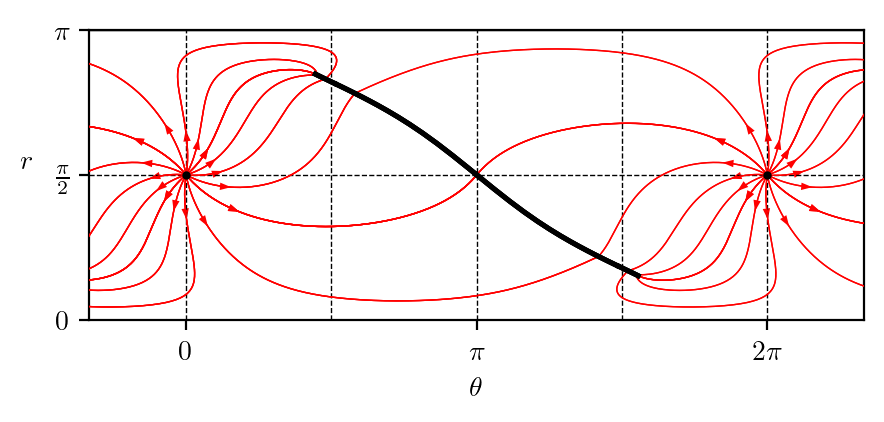

In [67]:
fig2d_synthesis.savefig('landau_finsler_cut_2D_geodesics.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_synthesis

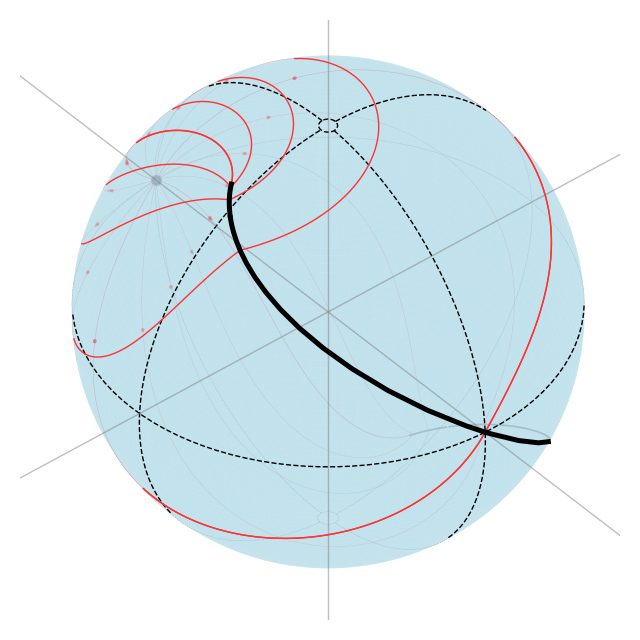

In [68]:
figs3d_synthesis[0].savefig('landau_finsler_cut_3D_geodesics.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_synthesis[0]

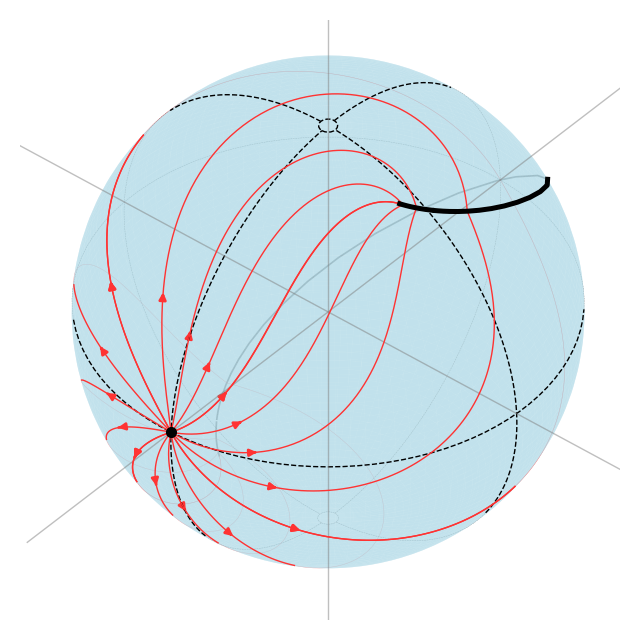

In [69]:
figs3d_synthesis[1].savefig('landau_finsler_cut_3D_geodesics_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_synthesis[1]

## Spheres

In [70]:
sphere = geometry2d.sphere.Sphere(wavefront, t_cut_final)
tfs_wavefronts = np.arange(0.1, 3.5, 0.1)
tfs_wavefronts = [tf_cut_max, 1.25, 2.01]
if False:
    for tf in tfs_wavefronts:
        print(tf)
        sphere.compute(tf)

In [71]:
LW_SPHERE_2D = 0.8
LW_SPHERE_3D = 1.2

tfs = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.1, 2.3, 2.5])

tfs = np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4])

cameras=[{'azimuth': 40, 'elevation': -40}, {'azimuth': 140, 'elevation': -40}]
for i in range(len(tfs)):
    tf = tfs[i]
    if i == 0:
        fig2d_sphere = sphere.plot(tf, view=PLANE, color=color_sphere, figsize=(5,5), linewidth=LW_SPHERE_2D)
        fig2d_sphere = update_2d_plot(fig2d_sphere)
        figs3d_sphere = []
        for camera in cameras:
            azimuth = camera['azimuth']
            elevation = camera['elevation']
            fig3d_sphere = sphere.plot(tf, view=SPHERE, color=color_sphere, linewidth=LW_SPHERE_3D, 
                                             azimuth=azimuth, elevation=elevation, figsize=(3,3))
            figs3d_sphere.append(fig3d_sphere)
    else:
        sphere.plot(tf, view=PLANE, color=color_sphere, figure=fig2d_sphere, linewidth=LW_SPHERE_2D)
        for fig3d_sphere in figs3d_sphere:
            sphere.plot(tf, view=SPHERE, color=color_sphere, figure=fig3d_sphere, linewidth=LW_SPHERE_3D)

<Figure size 640x480 with 0 Axes>

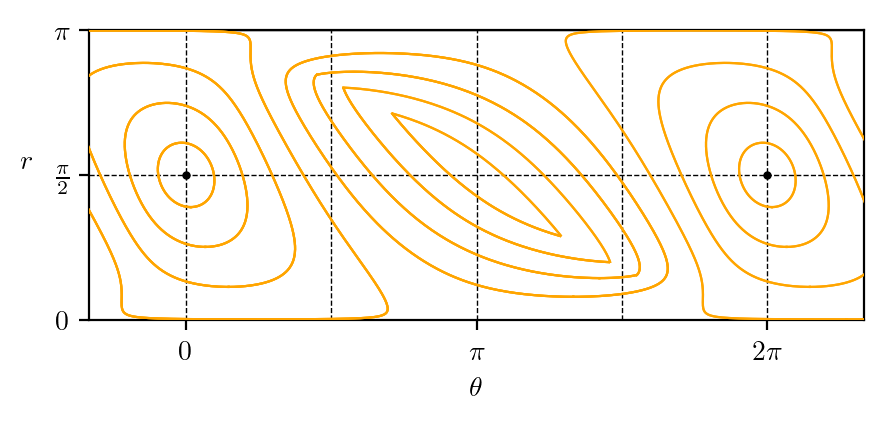

In [72]:
fig2d_sphere

In [73]:
LW_CUT = 1.8

# plot cut locus
fig2d_sphere = splitting.plot(['top', 'bottom', 'middle_north', 'middle_south'], 
                              linewidth=LW_CUT, view=PLANE, figure=fig2d_sphere,
                              color=color_cut_locus)

for fig3d_sphere in figs3d_sphere:
    fig3d_sphere = splitting.plot(['top', 'bottom', 'middle_north', 'middle_south'], 
                                  linewidth=LW_CUT, view=SPHERE, figure=fig3d_sphere,
                                  color=color_cut_locus)

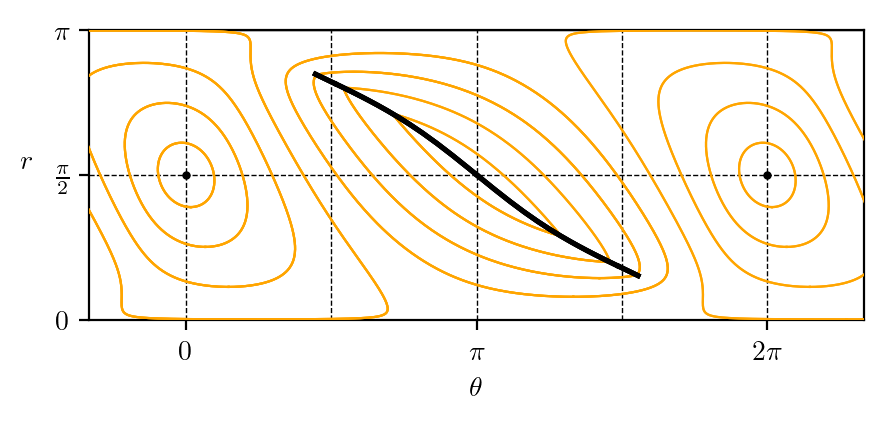

In [74]:
fig2d_sphere.savefig('landau_finsler_spheres_2D_cut.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_sphere

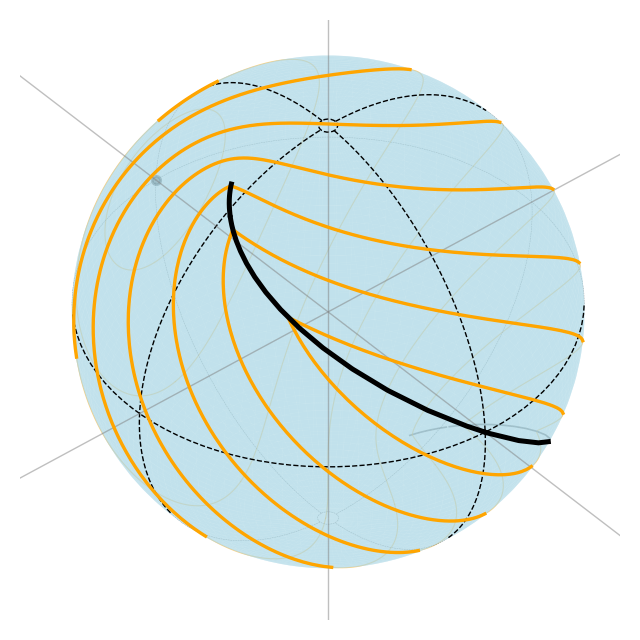

In [75]:
figs3d_sphere[0].savefig('landau_finsler_spheres_3D_cut.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_sphere[0]

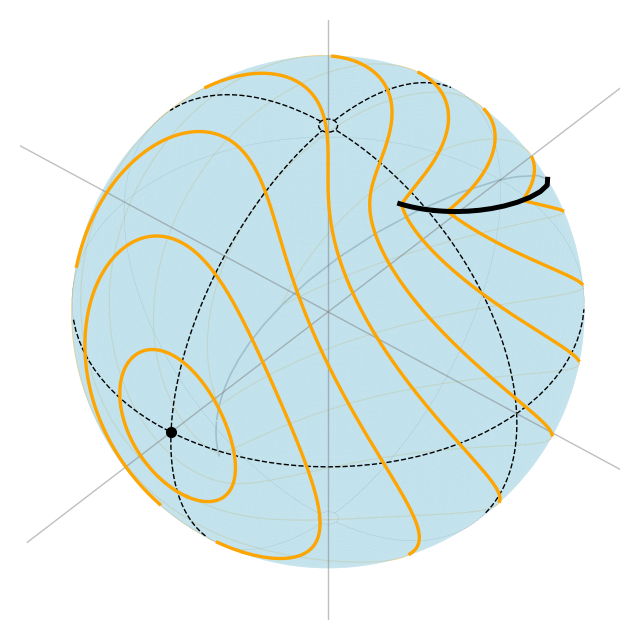

In [76]:
figs3d_sphere[1].savefig('landau_finsler_spheres_3D_cut_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_sphere[1]

In [77]:
LW_CONJ = 1.5

# plot conj locus
fig2d_sphere = conjugate.plot(linewidth=LW_CONJ, view=PLANE, figure=fig2d_sphere,
                              color=color_conjugate)

for fig3d_sphere in figs3d_sphere:
    fig3d_sphere = conjugate.plot(linewidth=LW_CONJ, view=SPHERE, figure=fig3d_sphere,
                                  color=color_conjugate, plot_surface=False)

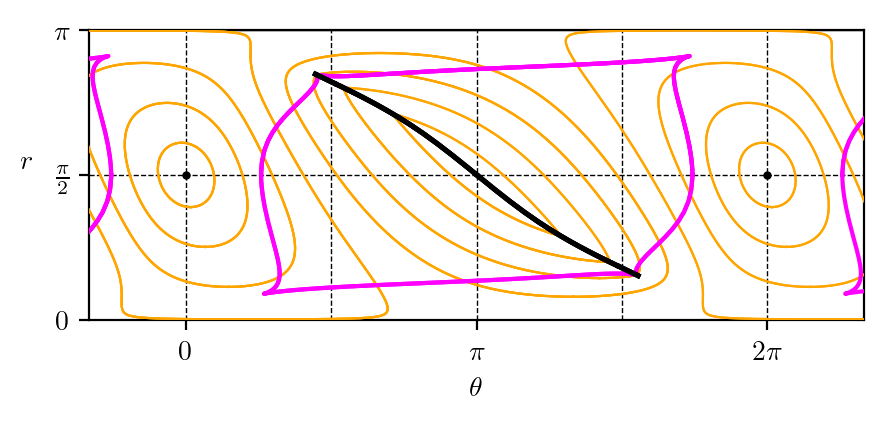

In [78]:
fig2d_sphere.savefig('landau_finsler_spheres_2D_cut_conj.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
fig2d_sphere

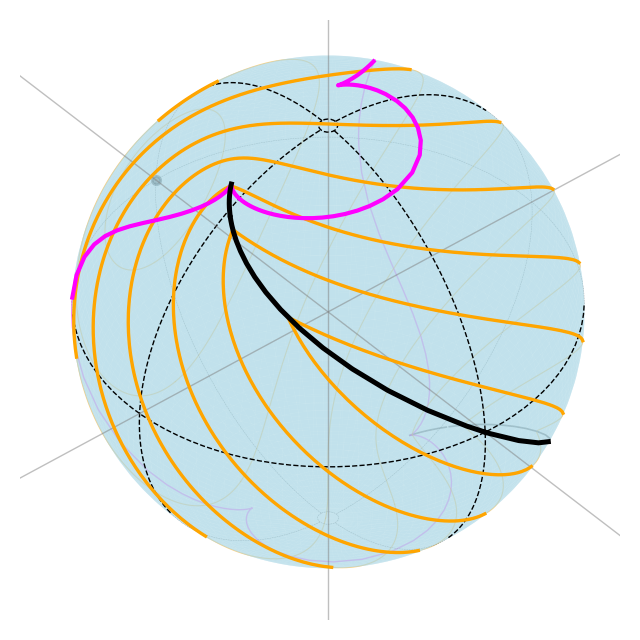

In [79]:
figs3d_sphere[0].savefig('landau_finsler_spheres_3D_cut_conj.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_sphere[0]

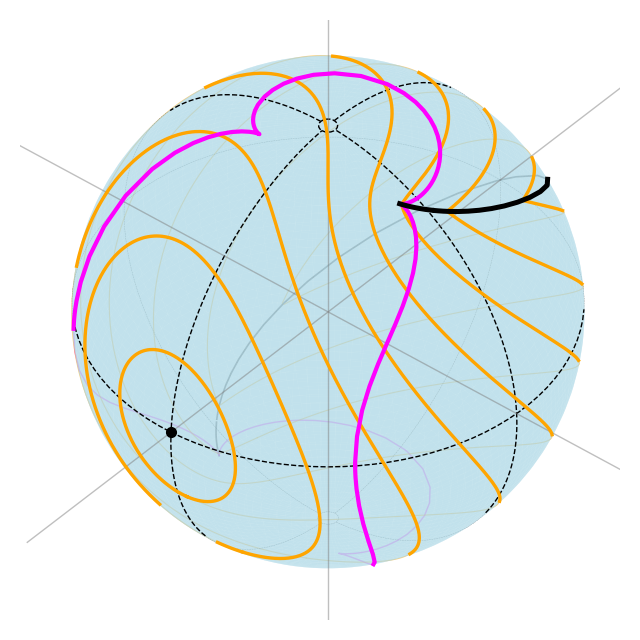

In [80]:
figs3d_sphere[1].savefig('landau_finsler_spheres_3D_cut_conj_bis.pdf', dpi=300, transparent=True, format="pdf", bbox_inches='tight')
figs3d_sphere[1]

# TEST

In [ ]:
from enum import Enum                     # for 2D vs 2D plots
import numpy as np                        # scientific computing tools

import matplotlib.pyplot as plt           # for plots
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D   # for 3D plots
plt.rcParams.update({"text.usetex":True, "font.family":"sans-serif", "font.sans-serif":["Helvetica"]}) # font properties
from matplotlib.colors import LightSource

# Kind of coordinates
class Coords(Enum):
    PLANE=2   # 2D
    SPHERE=3  # 3D
    
# z orders
z_order_sphere     = 0;  zc = 100
z_order_conj_surf  = zc; zc = zc+1
z_order_axes       = zc; zc = zc+1
z_order_geodesics  = zc; zc = zc+1
z_order_wavefront  = zc; zc = zc+1
z_order_ball       = z_order_wavefront
z_order_conjugate  = zc; zc = zc+1
z_order_splitting  = zc; zc = zc+1
z_order_q0         = zc; zc = zc+1
delta_zo_back = 50

# Parameters for the 3D view
elevation__ = -10
azimuth__   = 20
dist__      = 10

# figure parameters
dpi__ = 200
figsize_2d__ = (3,3)
figsize_3d__ = (2,2)

#
alpha_sphere = 0.5

# 2D to 3D coordinates
def coord3d(theta, phi, epsilon):
    v = -theta
    u = phi
    coefs = (1., 1., epsilon)                   # Coefficients in (x/a)**2 + (y/b)**2 + (z/c)**2 = 1 
    rx, ry, rz = coefs                          # Radii corresponding to the coefficients
    x = rx * np.multiply(np.cos(u), np.cos(v))
    y = ry * np.multiply(np.cos(u), np.sin(v))
    z = rz * np.sin(u)
    return x, y, z

def get_cam(elev, azimuth, dist):
    ce   = np.cos(2*np.pi*elev/360)
    se   = np.sin(2*np.pi*elev/360)
    ca   = np.cos(2*np.pi*azimuth/360)
    sa   = np.sin(2*np.pi*azimuth/360)
    cam  = np.array([ dist*ca*ce, dist*sa*ce, dist*se])
    return cam
    
def decorate_2d(ax, q0=None):
    
    x   = [-np.pi, np.pi, np.pi, -np.pi]
    y   = [np.pi/2, np.pi/2, np.pi/2+1, np.pi/2+1]
    ax.fill(x, y, color=(0.95, 0.95, 0.95))
    y   = [-(np.pi/2+1), -(np.pi/2+1), -np.pi/2, -np.pi/2]
    ax.fill(x, y, color=(0.95, 0.95, 0.95))
    ax.set_xlabel(r'$\theta$', fontsize=10)
    ax.set_ylabel(r'$\varphi$', fontsize=10)
    ax.axvline(0, color='k', linewidth=0.5, linestyle="dashed", zorder=z_order_axes)
    ax.axhline(0, color='k', linewidth=0.5, linestyle="dashed", zorder=z_order_axes)
    ax.axhline(-np.pi/2, color='k', linewidth=0.5, zorder=z_order_axes)
    ax.axhline( np.pi/2, color='k', linewidth=0.5, zorder=z_order_axes)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.set_aspect('equal', 'box')

    if not(q0 is None):
        r = q0[0]
        θ = q0[1]
        φ = r - np.pi/2
        ax.plot(θ, φ, marker="o", markersize=2, markeredgecolor="black", markerfacecolor="black", zorder=z_order_q0)  
        ax.plot(θ+2*np.pi, φ, marker="o", markersize=2, markeredgecolor="black", markerfacecolor="black", zorder=z_order_q0)  
        ax.plot(θ-2*np.pi, φ, marker="o", markersize=2, markeredgecolor="black", markerfacecolor="black", zorder=z_order_q0)  
    
def init_figure_2d(q0=None, *, dpi=dpi__, figsize=figsize_2d__):
    
    fig = Figure(dpi=dpi)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    fig.patch.set_alpha(0.0)
    ax  = fig.add_subplot(111)
    ax.patch.set_alpha(0.0)
    decorate_2d(ax, q0)
    return fig

def plot_2d(fig, θ, φ, *, color='b', linewidth=0.5, zorder=1, linestyle='solid'):
    ax = fig.axes[0]
    ax.plot(θ, φ, color=color, linewidth=linewidth, zorder=zorder, linestyle=linestyle)
    ax.plot(θ+2*np.pi, φ, color=color, linewidth=linewidth, zorder=zorder, linestyle=linestyle)
    ax.plot(θ-2*np.pi, φ, color=color, linewidth=linewidth, zorder=zorder, linestyle=linestyle)

def decorate_3d(ax, epsilon, q0=None, elevation=elevation__, azimuth=azimuth__):
    
    ax.set_axis_off()
    coefs = (1., 1., epsilon)              # Coefficients in (x/a)**2 + (y/b)**2 + (z/c)**2 = 1 
    rx, ry, rz = coefs                     # Radii corresponding to the coefficients

    # Set of all spherical angles:
    v = np.linspace(-np.pi, np.pi, 100)
    u = np.linspace(-np.pi/2, np.pi/2, 100)

    # Cartesian coordinates that correspond to the spherical angles
    x = rx * np.outer(np.cos(u), np.cos(v))
    y = ry * np.outer(np.cos(u), np.sin(v))
    z = rz * np.outer(np.sin(u), np.ones_like(v))

    # Landscape
    ZSPHERE = z

    # this is used to set the graph color to blue
    blue = np.array([1, 1, 1])
    rgb = np.tile(blue, (ZSPHERE.shape[0], ZSPHERE.shape[1], 1))

    ls = LightSource(azdeg=azimuth, altdeg=elevation, hsv_min_val=0, hsv_max_val=1, hsv_min_sat=1, hsv_max_sat=0)
    illuminated_surface = ls.shade_rgb(rgb, ZSPHERE)

    # Plot:
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, \
                    color='lightblue', 
                    linewidth=0, facecolors=illuminated_surface,
                    alpha=alpha_sphere, antialiased=True, edgecolor='none', zorder=z_order_sphere)

    # initial point
    if not(q0 is None):
        r = q0[0]
        θ = q0[1]
        φ = r - np.pi/2
        x, y, z = coord3d(θ, φ, epsilon)
        cam = get_cam(elevation, azimuth, dist__)
        ps = x*cam[0]+y*cam[1]+z*cam[2]
        if ps>0: # back
            zo = -z_order_q0 # - delta_zo_back
            al = 0.5
        else:
            zo = z_order_q0
            al = 1.0
        ax.plot(x, y, z, marker="o", markersize=3, alpha=al, \
                markeredgecolor="black", markerfacecolor="black", zorder=zo)

    # add one meridian
    N = 100
    if not(q0 is None):
        θ = q0[1]*np.ones(N)
    else:
        θ = 0*np.ones(N)
    φ = np.linspace(0, 2*np.pi, N)
    x, y, z = coord3d(θ, φ, epsilon)
    plot3d(ax, x, y, z, elevation, azimuth, color="black", \
            linewidth=0.5, linestyle="dashed", zorder=z_order_axes)

    # add equator
    N = 100
    θ = np.linspace(0, 2*np.pi, N)
    φ = 0*np.ones(N)
    x, y, z = coord3d(θ, φ, epsilon)
    plot3d(ax, x, y, z, elevation, azimuth, color="black", \
            linewidth=0.5, linestyle="dashed", zorder=z_order_axes)
    
    # Adjustment of the axes, so that they all have the same span:
    max_radius = max(rx, ry, rz)
    for axis in 'xyz':
        getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

    ax.view_init(elev=elevation, azim=azimuth) # Reproduce view
    #ax.dist = dist__
    ax.set_box_aspect(None, zoom=dist__)
    
    ax.set_xlim(np.array([-rx,rx])*.67)
    ax.set_ylim(np.array([-ry,ry])*.67)
    ax.set_zlim(np.array([-rz,rz])*.67)

    # 
    ax.set_aspect('equal', 'box')   

def init_figure_3d(epsilon, q0=None, elevation=elevation__, azimuth=azimuth__, *, 
                   dpi=dpi__, figsize=figsize_3d__):
    
    fig = Figure(dpi=dpi)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.patch.set_alpha(0.0)
    ax = fig.add_subplot(111, projection='3d')
    ax.patch.set_alpha(0.0)
    plt.tight_layout()
    decorate_3d(ax, epsilon, q0, elevation, azimuth)
    return fig


def plot3d(ax, x, y, z, elevation, azimuth, color, linewidth, linestyle='solid', zorder=1):
    N = len(x)
    i = 0
    j = 1

    cam = get_cam(elevation, azimuth, dist__)
    ps = x[0]*cam[0]+y[0]*cam[1]+z[0]*cam[2]
    while i<N-1:
        ps_j = x[j]*cam[0]+y[j]*cam[1]+z[j]*cam[2]
        if (ps*ps_j<0) or (j==N-1):
            if ps>0:
                ls = linestyle
                lw = linewidth/3.0
                al = 0.5
                zo = -zorder
            else:
                ls = linestyle
                lw = linewidth
                al = 1.0
                zo = zorder
            ax.plot(x[i:j+1], y[i:j+1], z[i:j+1], color=color, \
                    linewidth=lw, linestyle=ls, zorder=zo, alpha=al)
            i = j
            ps = ps_j
        j = j+1

# get surface coordinates from a closed curve defined by spherical coordinates
def surface_from_spherical_curve(x, y, epsilon):
    N = 100
    xmin = np.min(x)
    xmax = np.max(x)
    
    X = np.zeros((N, N))
    Y = np.zeros((N, N))
    
    xs = np.linspace(xmin, xmax, N)
    for i in range(N):
        x_current = xs[i]
        # find the two intersections of the curve with x_current
        ii  = np.argwhere(np.multiply(x[1:]-x_current, \
                                      x[0:-1]-x_current)<=0)
        #
        k   = ii[0][0]
        xk  = x[k]
        xkp = x[k+1]
        λ   = (x_current-xk)/(xkp-xk)
        y1  = y[k]+λ*(y[k+1]-y[k])
        #
        k   = ii[1][0]
        xk  = x[k]
        xkp = x[k+1]
        if abs(xkp-xk)>1e-12:
            λ = (x_current-xk)/(xkp-xk)
        else:
            λ = 0
        y2  = y[k]+λ*(y[k+1]-y[k])
        #
        ymin = min(y1, y2)
        ymax = max(y1, y2)
        ys = np.linspace(ymin, ymax, N)
        X[:, i] = x_current*np.ones(N)
        Y[:, i] = ys
    
    # cartesian
    XX = np.zeros((N, N))
    YY = np.zeros((N, N))
    ZZ = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            XX[i,j], YY[i,j], ZZ[i,j] = coord3d(X[i,j], Y[i,j], \
                                                epsilon)

    return XX, YY, ZZ
        
def plot_surface(fig, X, Y, Z, *, color='b', alpha=0.5, zorder=1):
    #
    ax = fig.axes[0]
    ax.plot_surface(X, Y, Z,  rstride=1, cstride=1, \
                color=color, alpha=alpha, antialiased=True, zorder=zorder)

In [ ]:
import numpy as np

class Sphere():
    
    def __init__(self, wavefront, t_cut):
        
        self.wavefront     = wavefront
        self.t_cut         = t_cut
        self.problem       = wavefront.problem
        self.data          = self.problem.data
        self.data_name     = 'sphere'
        self.label_default = 'default'
        self.color         = 'blue'
        self.linewidth     = 0.5
        self.zorder        = geometry2d.plottings.z_order_ball
        
    def exists_from_label__(self, tf, label):
        exists = False
        if self.data is not None and self.data.contains(self.data_name):
            spheres = self.data.get(self.data_name) # list of spheres
            for s in spheres: # iterate over the spheres
                # a sphere is a dictionnary with keys: label, locus
                s['locus'] = geometry2d.problem.SphereLocus(s['locus'])
                if s['label'] == label and abs(s['locus'].tf - tf) < 1e-10:
                    exists = True
                    break
        return exists
    
    def exists_from_tf(self, tf):
        # check if there is at least one sphere at tf
        exists = False
        if self.data is not None and self.data.contains(self.data_name):
            spheres = self.data.get(self.data_name)
            for s in spheres:
                s['locus'] = geometry2d.problem.SphereLocus(s['locus'])
                if abs(s['locus'].tf - tf) < 1e-10:
                    exists = True
                    break
        return exists
    
    def get_from_label__(self, tf, label):
        if self.data is not None and self.data.contains(self.data_name):
            spheres = self.data.get(self.data_name)
            for s in spheres:
                s['locus'] = geometry2d.problem.SphereLocus(s['locus'])
                if s['label'] == label and abs(s['locus'].tf - tf) < 1e-10:
                    return s
        return None
    
    def get_from_tf(self, tf):
        # return all the spheres at tf
        spheres_at_tf = {}
        if self.data is not None and self.data.contains(self.data_name):
            spheres = self.data.get(self.data_name)
            for s in spheres:
                s['locus'] = geometry2d.problem.SphereLocus(s['locus'])
                if abs(s['locus'].tf - tf) < 1e-10:
                    # add the sphere to the dictionary
                    # the key is the label and the value is the locus
                    spheres_at_tf[s['label']] = s['locus']
        return spheres_at_tf
    
    def remove_from_label__(self, tf, label):
        if self.data is not None and self.data.contains(self.data_name):
            spheres = self.data.get(self.data_name)
            for s in spheres:
                s['locus'] = geometry2d.problem.SphereLocus(s['locus'])
                if s['label'] == label and abs(s['locus'].tf - tf) < 1e-10:
                    spheres.remove(s)
                    break
            self.data.update({self.data_name: spheres})
            
    def remove_from_tf(self, tf):
        if self.data is not None and self.data.contains(self.data_name):
            spheres = self.data.get(self.data_name)
            for s in spheres:
                s['locus'] = geometry2d.problem.SphereLocus(s['locus'])
                if abs(s['locus'].tf - tf) < 1e-10:
                    spheres.remove(s)
            self.data.update({self.data_name: spheres})
    
    def compute_sphere_locus__(self, wavefront_locus, tf):
        
        states = wavefront_locus.states
        alphas = wavefront_locus.alphas
        
        # compute the sphere
        states_sphere = np.zeros(states.shape)
        for i in range(len(states)):
            state = states[i]
            alpha = alphas[i]
            if tf < self.t_cut(alpha):
                states_sphere[i, :] = state
            else:
                states_sphere[i, :] = np.nan * np.ones(state.shape)
        
        # return the sphere
        return geometry2d.problem.SphereLocus((tf, states_sphere, alphas))
    
    def compute(self, tf, *, label=None, save=True, reset=False, load=True):
        
        if reset:
            if label is None:
                self.remove_from_tf(tf)
            else:
                self.remove_from_label__(tf, label)
        
        # if data is None then force save to False
        if self.data is None:
            save = False
            load = False
            
        if label==None and load and not reset:
            if self.exists_from_tf(tf):
                return self.get_from_tf(tf)
        elif not label==None and load and not reset:
            if self.exists_from_label__(tf, label):
                return self.get_from_label__(tf, label)
            
        # if here, then the spheres are not in the data
        # get the wavefronts from which we will compute the spheres
        if label==None:
            if self.wavefront.exists_from_tf(tf):
                wavefronts = self.wavefront.get_from_tf(tf)
            else:
                raise ValueError('There is no wavefront at tf.')
        else:
            if self.wavefront.exists_from_label__(tf, label):
                wavefront_locus = self.wavefront.get_from_label__(tf, label)
                wavefronts = {label: wavefront_locus}
            else:
                raise ValueError('There is no wavefront with label {} at tf.'.format(label))
            
        # compute the spheres
        spheres = []
        for label, wavefront_locus in wavefronts.items():
            # compute the sphere
            sphere_locus = self.compute_sphere_locus__(wavefront_locus, tf)
            # add the sphere to the dictionary
            spheres.append({'label': label, 'locus': sphere_locus})
            
        # save the spheres
        if save:
         
            # get the data
            if self.data.contains(self.data_name):
                data_spheres = self.data.get(self.data_name)
            else:
                data_spheres = []  
                
            # update the data
            for sphere in spheres:
                # remove the sphere if it already exists
                data_sphere = sphere.copy()
                data_sphere['locus'] = sphere['locus'].get_data()
                # add the sphere
                data_spheres.append(data_sphere)
                
            # save the data
            self.data.update({self.data_name: data_spheres})
            
        # return the spheres: if one sphere then return the sphere else return the array
        if len(spheres) == 1:
            return spheres[0]
        else:
            return spheres
        
    def plot_2d(self, sphere_loci, *, color=None, linewidth=None, zorder=None, figure=None,
                dpi=geometry2d.plottings.dpi__, figsize=geometry2d.plottings.figsize_2d__):
        
        # initialize the parameters
        if color is None:
            color = self.color
        if linewidth is None:
            linewidth = self.linewidth
        if zorder is None:
            zorder = self.zorder
        
        # initialize the figure
        if figure is None:
            figure = geometry2d.plottings.init_figure_2d(self.problem.initial_point, dpi=dpi, figsize=figsize)
            
        # check if sphere_loci is a list
        if not isinstance(sphere_loci, list):
            sphere_loci = [sphere_loci]
            
        # iterate over the sphere_loci
        for w in sphere_loci:
            
            # change of coordinates
            # from (r, θ) to (θ, φ), with φ = r - π / 2
            # r = π / 2 is the equator
            r = w['locus'].states[:, 0]
            θ = w['locus'].states[:, 1]
            φ = r - np.pi/2
            
            # plot the sphere_loci
            geometry2d.plottings.plot_2d(figure, θ,         φ, color=color, linewidth=linewidth, zorder=zorder)
            geometry2d.plottings.plot_2d(figure, θ+2*np.pi, φ, color=color, linewidth=linewidth, zorder=zorder)
            geometry2d.plottings.plot_2d(figure, θ-2*np.pi, φ, color=color, linewidth=linewidth, zorder=zorder)
            
        return figure
 
    def plot_3d(self, sphere_loci, *,
                elevation=geometry2d.plottings.elevation__,
                azimuth=geometry2d.plottings.azimuth__, 
                color=None, linewidth=None, zorder=None, figure=None,
                dpi=geometry2d.plottings.dpi__, figsize=geometry2d.plottings.figsize_3d__):
        
        # initialize the parameters
        if color is None:
            color = self.color
        if linewidth is None:
            linewidth = self.linewidth
        if zorder is None:
            zorder = self.zorder
            
        # initialize the figure
        if figure is None:
            figure = geometry2d.plottings.init_figure_3d(self.problem.epsilon, 
                                                    self.problem.initial_point,
                                                    elevation,
                                                    azimuth, dpi=dpi, figsize=figsize)
            
        # check if sphere_loci is a list
        if not isinstance(sphere_loci, list):
            sphere_loci = [sphere_loci]
            
        # iterate over the sphere_loci
        for w in sphere_loci:
            
            # change of coordinates
            # from (r, θ) to (θ, φ), with φ = r - π / 2
            # r = π / 2 is the equator
            r = w['locus'].states[:, 0]
            θ = w['locus'].states[:, 1]
            φ = r - np.pi/2
            
            # plot the sphere_loci
            x, y, z = geometry2d.plottings.coord3d(θ, φ, self.problem.epsilon)
            plot_3d(figure, x, y, z, color=color, linewidth=linewidth, zorder=zorder)
            
        return figure
       
    def plot(self, tf, labels=None, *,
            view=geometry2d.plottings.Coords.SPHERE, 
            elevation=geometry2d.plottings.elevation__,
            azimuth=geometry2d.plottings.azimuth__, 
            color=None, linewidth=None, zorder=None, figure=None, dpi=None, figsize=None):
        
        # if there is no sphere at tf then raise an error
        if not self.exists_from_tf(tf):
            raise ValueError('There is no sphere at tf.')
        
        # get the spheres at tf
        spheres_at_tf = self.get_from_tf(tf)
        
        # initialize the parameters
        if labels is None:
            labels = ['left', 'right']
        elif not (isinstance(labels, list) or isinstance(labels, np.ndarray) or isinstance(labels, tuple)):
            labels = [labels]
            
        if dpi is None:
            dpi = geometry2d.plottings.dpi__
        if figsize is None:
            if view == geometry2d.plottings.Coords.SPHERE:
                figsize = geometry2d.plottings.figsize_3d__
            elif view == geometry2d.plottings.Coords.PLANE:
                figsize = geometry2d.plottings.figsize_2d__
                
        # check if there are both 'left' and 'right' in the labels
        left_right_in_labels_and_SPHERE = ('left' in labels) and ('right' in labels) #and \
                                            #(view == geometry2d.plottings.Coords.SPHERE)
        # if left_right_in_labels is True, then we concatenate the spheres before plotting
        if left_right_in_labels_and_SPHERE:
            # get the spheres at tf. Then, concatenate and plot
            wl = spheres_at_tf['left']
            wr = spheres_at_tf['right']
            r = np.concatenate((wr.states[:, 0], wl.states[:, 0], [wr.states[0, 0]]))
            if abs(wr.states[-1, 1] - wl.states[0, 1]) > np.pi:
                θ = np.concatenate((wr.states[:, 1], wl.states[:, 1]+2*np.pi, [wr.states[0, 1]]))
            else:
                θ = np.concatenate((wr.states[:, 1], wl.states[:, 1], [wr.states[0, 1]]))
            α = np.concatenate((wr.alphas, wl.alphas, [wr.alphas[0]]))
            sphere_locus = geometry2d.problem.SphereLocus((tf, np.array([r, θ]).T, α))
            # plot
            if view == geometry2d.plottings.Coords.SPHERE:
                figure = self.plot_3d([{'label':'default', 'locus':sphere_locus}], 
                                    elevation=elevation, azimuth=azimuth, 
                                    color=color, linewidth=linewidth, zorder=zorder, 
                                    figure=figure, dpi=dpi, figsize=figsize)
            elif view == geometry2d.plottings.Coords.PLANE:
                figure = self.plot_2d([{'label':'default', 'locus':sphere_locus}], 
                                    color=color, linewidth=linewidth, zorder=zorder, 
                                    figure=figure, dpi=dpi, figsize=figsize)
            else:
                raise ValueError('The view is not valid.')
                
        # iterates over the labels and create a list of spheres
        spheres_loci = []
        for label in labels:
            # do not append if label is 'left' or 'right' and left_right_in_labels is True
            if (left_right_in_labels_and_SPHERE) and ((label == 'left') or (label == 'right')):
                continue # this skip the rest of the loop and goes to the next iteration
            spheres_loci.append({'label':label, 'locus':spheres_at_tf[label]})
            
        # plot
        if view == geometry2d.plottings.Coords.SPHERE:
            figure = self.plot_3d(spheres_loci, 
                                   elevation=elevation, azimuth=azimuth, 
                                   color=color, linewidth=linewidth, zorder=zorder, 
                                   figure=figure, dpi=dpi, figsize=figsize)
        elif view == geometry2d.plottings.Coords.PLANE:
            figure = self.plot_2d(spheres_loci, 
                                   color=color, linewidth=linewidth, zorder=zorder, 
                                   figure=figure, dpi=dpi, figsize=figsize)
        else:
            raise ValueError('The view is not valid.')
        
        return figure      

In [ ]:
sphere = Sphere(wavefront, t_cut_improved)

In [ ]:
def plot_3d(fig, x, y, z, *, color='b', linewidth=1, zorder=1, linestyle='solid'):
    #
    ax = fig.axes[0]
    # get azimuth and elevation
    azimuth   = ax.azim
    elevation = ax.elev
    #
    N = len(x)
    i = 0
    j = 1
    #
    cam = get_cam(elevation, azimuth, dist__)
    ps = x[0]*cam[0]+y[0]*cam[1]+z[0]*cam[2]
    #
    while i<N-1:
        if np.isnan(x[i]):
            i = i+1
        else:
            if np.isnan(x[j]):
                ps_j = ps
            else:
                ps_j = x[j]*cam[0]+y[j]*cam[1]+z[j]*cam[2]
            if (ps*ps_j<0) or (j==N-1):
                if ps>0:
                    ls = linestyle #'solid'
                    lw = linewidth/3.0
                    al = 0.5
                    zo = -zorder
                else:
                    ls = linestyle #'solid'
                    lw = linewidth
                    al = 1.0
                    zo = zorder
                # we do not plot nan at the end of the array
                k = j
                while np.isnan(x[k]) or i==k:
                    k = k-1
                if k>i:
                    ax.plot(x[i:k+1], y[i:k+1], z[i:k+1], color=color, \
                                linewidth=lw, linestyle=ls, zorder=zo, alpha=al)
                i = j
            ps = ps_j
        j = j+1

In [ ]:
a = np.arange(10.0)
a[0] = np.nan * 1.0
b = np.nan * np.ones(a.shape)
np.all(np.isnan(b))

In [ ]:
LW_SPHERE_2D = 0.8
LW_SPHERE_3D = 1.2

tfs = np.array([1.8, 2.1, 2.3, 2.5])
#tfs = np.array([2.3])

cameras=[{'azimuth': 40, 'elevation': -40}] #, {'azimuth': 140, 'elevation': -40}]
for i in range(len(tfs)):
    tf = tfs[i]
    if i == 0:
        fig2d_sphere = sphere.plot(tf, view=PLANE, color=color_sphere, figsize=(5,5), linewidth=LW_SPHERE_2D)
        fig2d_sphere = update_2d_plot(fig2d_sphere)
        figs3d_sphere = []
        for camera in cameras:
            azimuth = camera['azimuth']
            elevation = camera['elevation']
            fig3d_sphere = sphere.plot(tf, view=SPHERE, color=color_sphere, linewidth=LW_SPHERE_3D, 
                                             azimuth=azimuth, elevation=elevation, figsize=(3,3))
            figs3d_sphere.append(fig3d_sphere)
    else:
        sphere.plot(tf, view=PLANE, color=color_sphere, figure=fig2d_sphere, linewidth=LW_SPHERE_2D)
        for fig3d_sphere in figs3d_sphere:
            sphere.plot(tf, view=SPHERE, color=color_sphere, figure=fig3d_sphere, linewidth=LW_SPHERE_3D)

[-0.74745693 -0.72739913 -0.69769047 -0.66724382 -0.63634168 -0.60526804
 -0.58847166 -0.55767353 -0.52738194 -0.49782931 -0.47515025 -0.44741371
 -0.42091385 -0.3957696  -0.38991698 -0.36657381 -0.34474135 -0.32801741
 -0.30897696]
[0.61532516 0.62863285 0.64561952 0.65999091 0.67172652 0.68084852
 0.68471746 0.6899485  0.6928     0.69342303 0.69245528 0.68954199
 0.68493364 0.67884246 0.67717492 0.6695404  0.66089718 0.65321445
 0.64324256]
[-0.2503659  -0.27515677 -0.31048904 -0.34525018 -0.37927925 -0.41242684
 -0.42995709 -0.46148813 -0.4918297  -0.52089392 -0.54289771 -0.56951981
 -0.59472467 -0.61849764 -0.62401833 -0.64601803 -0.66660957 -0.68243348
 -0.70055139]

In [ ]:
figs3d_sphere[0]

In [ ]:
figs3d_sphere[1]